In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

data = pd.read_csv('collab_dataset.csv')
ratings_matrix = data.values
print(f"Dataset loaded with shape: {ratings_matrix.shape}")


Dataset loaded with shape: (1000, 3807)


In [17]:
np.random.seed(42)
non_nan_indices = np.array([(i, j) for i, j in zip(*np.where(~np.isnan(ratings_matrix)))])
np.random.shuffle(non_nan_indices)

train_size = int(len(non_nan_indices) * 0.8)
valid_size = int(len(non_nan_indices) * 0.1)

train_indices = non_nan_indices[:train_size]
valid_indices = non_nan_indices[train_size:train_size + valid_size]
test_indices = non_nan_indices[train_size + valid_size:]

print(f"Training size: {len(train_indices)}")
print(f"Validation size: {len(valid_indices)}")
print(f"Test size: {len(test_indices)}")


Training size: 8284
Validation size: 1035
Test size: 1036


In [19]:
train_matrix = np.full_like(ratings_matrix, np.nan)
for i, j in train_indices:
    train_matrix[i, j] = ratings_matrix[i, j]

global_mean = np.nanmean(train_matrix)
train_matrix_filled = np.nan_to_num(train_matrix - global_mean, nan=0)
print(f"Global mean: {global_mean:.4f}")


Global mean: 51.8394


In [21]:
def svd_predict(matrix, n_components=100):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(matrix)
    transformed = svd.transform(matrix)
    reconstructed = svd.inverse_transform(transformed) + global_mean
    return reconstructed

predicted_matrix_svd = svd_predict(train_matrix_filled)
print(f"SVD predictions (first 5 rows):\n{predicted_matrix_svd[:5]}")


SVD predictions (first 5 rows):
[[1.50916365e-02 5.17835982e+01 4.70110871e+01 ... 5.20350650e+01
  5.18394495e+01 5.21083133e+01]
 [5.18641192e+01 5.17770109e+01 5.22826393e+01 ... 5.19165834e+01
  5.18394495e+01 5.15563485e+01]
 [2.01853241e+00 5.18341763e+01 5.09544050e+01 ... 5.19768940e+01
  5.18394495e+01 5.22485810e+01]
 [2.98034331e+00 5.21129020e+01 5.10672153e+01 ... 5.20987142e+01
  5.18394495e+01 5.20061333e+01]
 [4.01843750e+00 5.18923710e+01 5.16598082e+01 ... 5.18692154e+01
  5.18394495e+01 5.03766828e+01]]


In [37]:
user_similarity = cosine_similarity(np.nan_to_num(train_matrix, nan=0))
predicted_matrix_user = np.dot(user_similarity, np.nan_to_num(train_matrix, nan=0))
user_similarity_sum = np.sum(user_similarity, axis=1)
predicted_matrix_user /= (user_similarity_sum[:, np.newaxis] + 1e-9)
print(f"User-based predictions (first 5 rows):\n{predicted_matrix_user[:5]}")


User-based predictions (first 5 rows):
[[1.08879348e+01 0.00000000e+00 1.72984693e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.28629800e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.02508228e+02 6.23964934e-03 3.74204178e-03 ... 4.99204291e-03
  0.00000000e+00 6.23960294e-03]
 [5.03493075e+02 6.25213791e-03 3.74953143e-03 ... 5.00203442e-03
  0.00000000e+00 6.25209142e-03]
 [5.04585682e+02 6.26623402e-03 3.75798514e-03 ... 5.01331203e-03
  0.00000000e+00 6.30539030e-03]]


In [39]:
predicted_matrix = 0.7 * predicted_matrix_svd + 0.3 * predicted_matrix_user
print(f"Combined predictions (first 5 rows):\n{predicted_matrix[:5]}")


Combined predictions (first 5 rows):
[[  3.27694457  36.24851876  33.42671503 ...  36.42454549  36.28761468
   36.4758193 ]
 [ 38.79077282  36.24390762  36.5978475  ...  36.34160839  36.28761468
   36.08944392]
 [152.16544112  36.28579528  35.6692061  ...  36.38532341  36.28761468
   36.5758786 ]
 [153.13416288  36.48090701  35.74817556 ...  36.47060053  36.28761468
   36.40616894]
 [154.1886109   36.32653958  36.16299314 ...  36.3099548   36.28761468
   35.26556958]]


In [41]:
best_f1, best_threshold = 0, 3.5
thresholds = np.arange(3.0, 4.5, 0.1)

for threshold in thresholds:
    valid_actual = [train_matrix[i, j] >= threshold for i, j in valid_indices if not np.isnan(train_matrix[i, j])]
    valid_predicted = [predicted_matrix[i, j] >= threshold for i, j in valid_indices if not np.isnan(train_matrix[i, j])]
    if valid_actual and valid_predicted:
        f1 = f1_score(valid_actual, valid_predicted)
        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold

print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.4f}")


Best Threshold: 3.50, Best F1 Score: 0.0000


In [43]:
test_actual = [ratings_matrix[i, j] >= best_threshold for i, j in test_indices if not np.isnan(ratings_matrix[i, j])]
test_predicted = [predicted_matrix[i, j] >= best_threshold for i, j in test_indices if not np.isnan(ratings_matrix[i, j])]
f1_test = f1_score(test_actual, test_predicted, zero_division=1)
print(f"Test F1 Score: {f1_test:.4f}")


Test F1 Score: 0.7257


In [45]:
def recommend_courses(user_id, train_matrix, similarity_matrix, top_n=5):
    user_ratings = train_matrix[user_id]
    predicted_ratings = np.dot(similarity_matrix[user_id], np.nan_to_num(train_matrix, nan=0)) / (
        np.sum(np.abs(similarity_matrix[user_id])) + 1e-9
    )
    recommendations = [i for i in np.argsort(predicted_ratings)[::-1] if np.isnan(user_ratings[i])][:top_n]
    return recommendations, predicted_ratings[recommendations]

user_id = 0
recommendations, scores = recommend_courses(user_id, train_matrix, user_similarity)
print(f"Recommended courses for User {user_id}:")
for course, score in zip(recommendations, scores):
    print(f"Course {course} with predicted score: {score:.4f}")


Recommended courses for User 0:
Course 1426 with predicted score: 0.2967
Course 2032 with predicted score: 0.2967
Course 3380 with predicted score: 0.2967
Course 3379 with predicted score: 0.2967
Course 2433 with predicted score: 0.2967


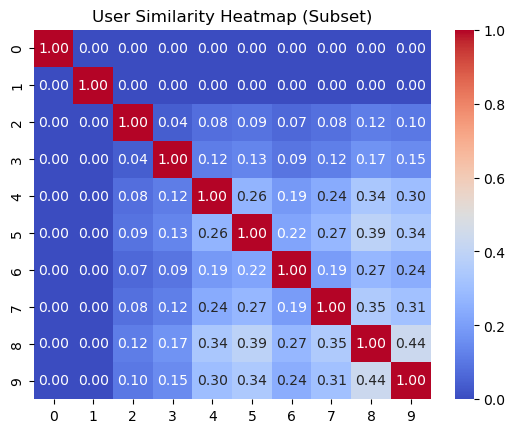

In [55]:
import seaborn as sns

# Select a subset of the user similarity matrix for better visualization
subset_user_similarity = user_similarity[:10, :10]

# Plot the heatmap
sns.heatmap(subset_user_similarity, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('User Similarity Heatmap (Subset)')
plt.show()


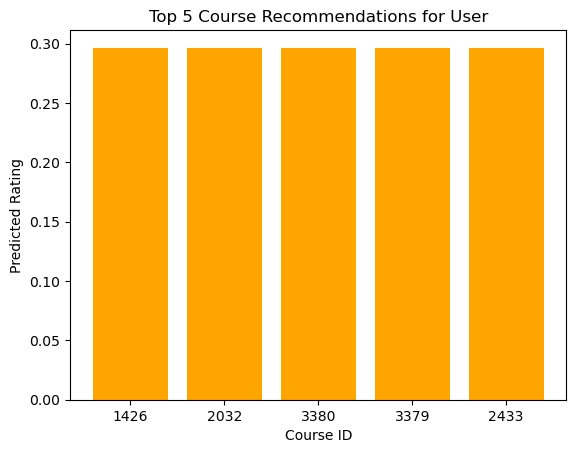

In [57]:
top_n_recommendations = recommendations[:5]
top_n_scores = scores[:5]

plt.bar(range(len(top_n_recommendations)), top_n_scores, tick_label=top_n_recommendations, color='orange')
plt.title('Top 5 Course Recommendations for User')
plt.xlabel('Course ID')
plt.ylabel('Predicted Rating')
plt.show()
